# Data Exploration
## Preamble 

In [13]:
#convert the dataset folder into pandas dataframe
import pandas as pd
from src.data_clean import build_dataframe
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm

## Testing plotting of the temperature

In [14]:
df_temp = build_dataframe("TEMP")
#df_BVP = build_dataframe("BVP")
df_EDA = build_dataframe("EDA")
df_HR = build_dataframe("HR")

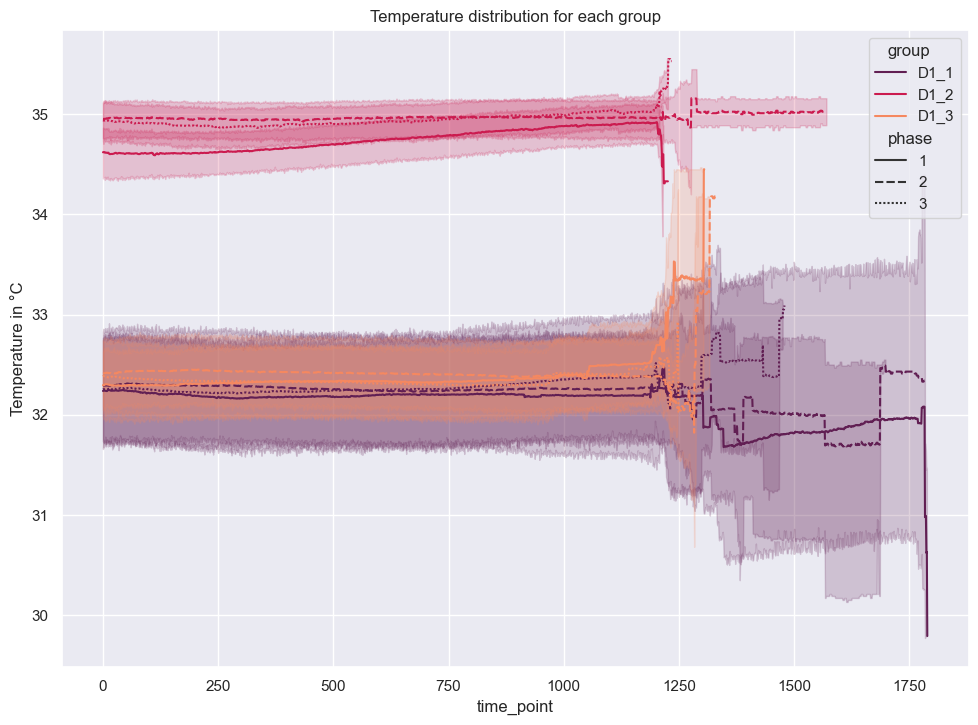

In [13]:
#plot the temperature data each group as density plot and each phase as line plot

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=df_temp, x="time_point", y="TEMP", hue="group", palette="rocket", style="phase")
plt.ylabel("Temperature in °C")
plt.title("Temperature distribution for each group")
plt.show()


In [15]:
#create a combined dataframe containing the temperature, EDA and HR data and combine on group, ID, round, phase and remove time_point
df_combined = pd.merge(df_temp, df_EDA, on=['group', 'ID', 'round', 'phase', 'time_point'])
df_combined = pd.merge(df_combined, df_HR, on=['group', 'ID', 'round', 'phase', 'time_point'])
df_combined.drop(columns=['time_x', 'time_y', 'time', 'sub_group', 'sub_group_x', 'sub_group_y', 'ID', 'group', 'round', 'phase', ], inplace=True)
#get dummies
#df_combined = pd.get_dummies(df_combined, columns=['group', 'phase'])
#remove duplicates
#df_combined.drop_duplicates(inplace=True)
df_combined

,TEMP,time_point,EDA,HR
0,30.97,0,0.185827,76.75
1,30.97,1,0.203768,76.75
2,30.97,2,0.192234,76.73
3,30.97,3,0.189671,76.72
4,31.01,4,0.185827,76.72
...,...,...,...,...
575022,32.15,307,0.971585,79.00
575023,33.16,308,0.524331,79.33
575024,33.16,308,0.970304,79.33
575025,32.15,308,0.524331,79.33


100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


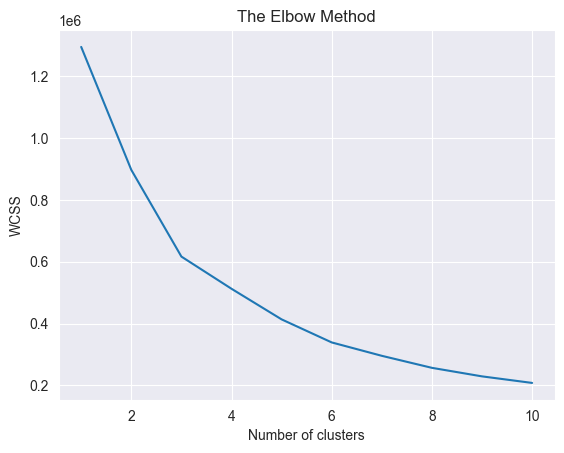

In [16]:
#do unsupervised learning on the combined dataframe

#scale the data
scaler = StandardScaler()
df_combined_scaled = scaler.fit_transform(df_combined)

#reduce the dimensionality
pca = PCA(n_components=2)
df_combined_pca = pca.fit_transform(df_combined_scaled)

#find the optimal number of clusters
wcss = []
for i in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42, n_init=10, max_iter=300)
    kmeans.fit(df_combined_pca)
    wcss.append(kmeans.inertia_)

#plot the elbow method
plt.plot(range(1, 11), wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

#fit the kmeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42, n_init=10, max_iter=300)
y_kmeans = kmeans.fit_predict(df_combined_pca)
y_kmeans = pd.DataFrame(y_kmeans, columns=['cluster'])
df_combined_pca = pd.DataFrame(df_combined_pca, columns=['pca1', 'pca2'])
df_combined_pca = pd.concat([df_combined_pca, y_kmeans], axis=1)

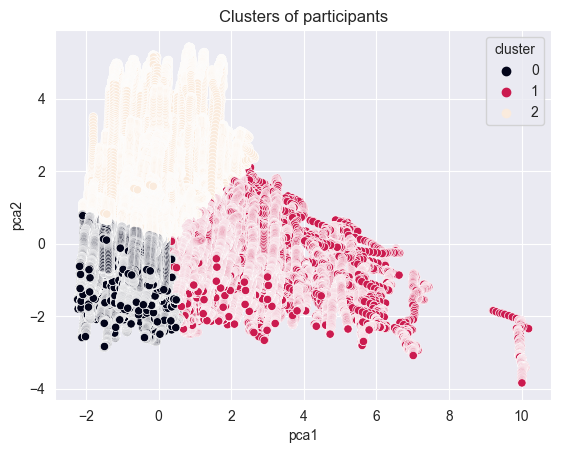

In [17]:
#plot the clusters
sns.set_style("darkgrid")
sns.scatterplot(data=df_combined_pca, x="pca1", y="pca2", hue="cluster", palette="rocket")

plt.title("Clusters of participants")
plt.show()

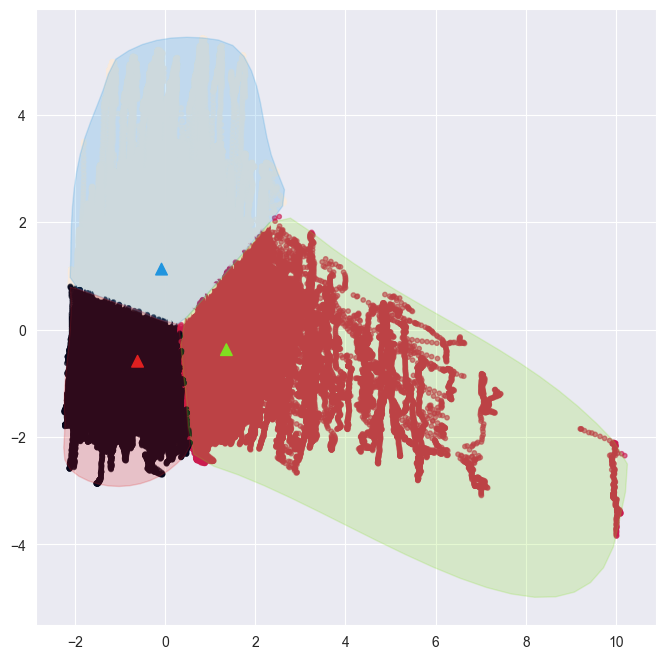

In [18]:
from scipy import interpolate
from scipy.spatial import ConvexHull

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
colors = ['#DF2020', '#81DF20', '#2095DF']

fig, ax = plt.subplots(1, figsize=(8,8))
plt.scatter(df_combined_pca.pca1, df_combined_pca.pca2, c=df_combined_pca.cluster, alpha = 0.6, s=10)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
    
for i in df_combined_pca.cluster.unique():
    # get the convex hull
    points = df_combined_pca[df_combined_pca.cluster == i][['pca1', 'pca2']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0, per=1)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=colors[i], alpha=0.2)
    
#plt.xlim(0,200)
#plt.ylim(0,200)

/Users/gustavlarsen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Uni/Computational Data Science/02582-Case2/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


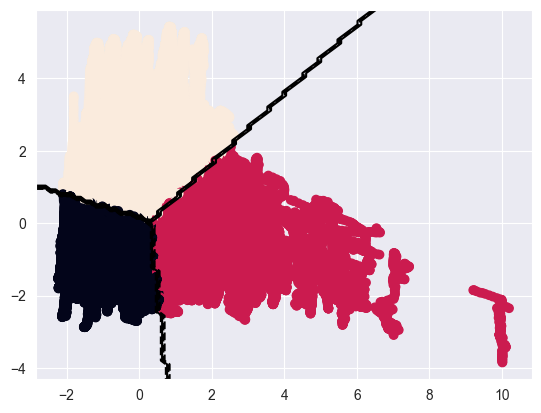

In [19]:
# Plot the data points with different colors for each cluster
from sklearn.svm import SVC
df_combined_pca = pca.fit_transform(df_combined_scaled)
plt.scatter(df_combined_pca[:,0], df_combined_pca[:,1], c=y_kmeans.cluster)

# Train an SVM classifier on the data, using the cluster labels as the target variable
svm = SVC(kernel='linear')
svm.fit(df_combined_pca, y_kmeans)

# Draw the decision boundary of the SVM to separate the clusters
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='k', linestyles=['--', '-', '--'])

# Show the plot
plt.show()